In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd

In [3]:
tracts = gpd.read_file('../GENERATED-DATA/crime_agg_by_tract.geojson')

In [4]:
tracts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
tracts = tracts.set_index("CD_GEOCODI")

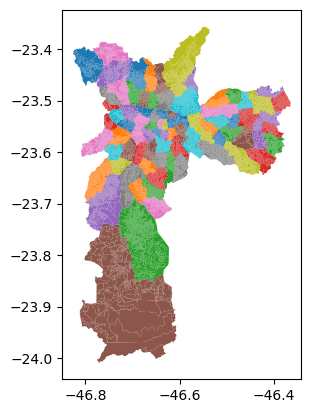

In [20]:
tracts.plot(column="NM_DISTRIT");

In [10]:
gpd.GeoDataFrame.dissolve?

Signature:
gpd.GeoDataFrame.dissolve(
    self,
    by=None,
    aggfunc='first',
    as_index=True,
    level=None,
    sort=True,
    observed=False,
    dropna=True,
    **kwargs,
)
Docstring:
Dissolve geometries within `groupby` into single observation.
This is accomplished by applying the `unary_union` method
to all geometries within a groupself.

Observations associated with each `groupby` group will be aggregated
using the `aggfunc`.

Parameters
----------
by : str or list-like, default None
    Column(s) whose values define the groups to be dissolved. If None,
    the entire GeoDataFrame is considered as a single group. If a list-like
    object is provided, the values in the list are treated as categorical
    labels, and polygons will be combined based on the equality of
    these categorical labels.
aggfunc : function or string, default "first"
    Aggregation function for manipulation of data associated
    with each group. Passed to pandas `groupby.agg` method.
    Accepte

In [44]:
districts = tracts.dissolve(by="NM_DISTRIT", as_index=False, aggfunc="sum")
districts

,NM_DISTRIT,geometry,CRIMES
0,ALTO DE PINHEIROS,"POLYGON ((-46.71932 -23.55333, -46.71996 -23.5...",1259
1,ANHANGUERA,"POLYGON ((-46.80715 -23.45412, -46.80745 -23.4...",918
2,ARICANDUVA,"POLYGON ((-46.52236 -23.58478, -46.52260 -23.5...",2837
3,ARTUR ALVIM,"POLYGON ((-46.49231 -23.55342, -46.49252 -23.5...",3545
4,BARRA FUNDA,"POLYGON ((-46.66813 -23.53322, -46.66860 -23.5...",6895
...,...,...,...
91,VILA MATILDE,"POLYGON ((-46.52761 -23.54663, -46.52791 -23.5...",2983
92,VILA MEDEIROS,"POLYGON ((-46.59088 -23.49963, -46.59106 -23.4...",2396
93,VILA PRUDENTE,"POLYGON ((-46.57879 -23.60053, -46.57880 -23.6...",4258
94,VILA SÔNIA,"POLYGON ((-46.75170 -23.60876, -46.75164 -23.6...",2875


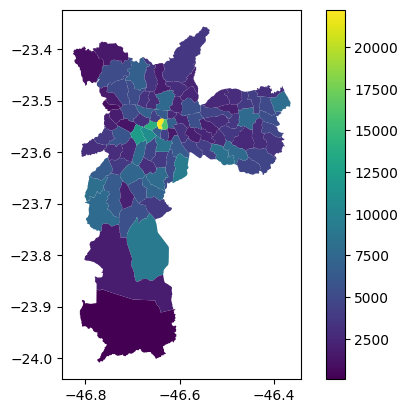

In [78]:
districts.plot(column="CRIMES", legend=True);

In [86]:
# convert the districts crs to one with meters as units
districts = districts.to_crs(epsg=31983)
districts.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

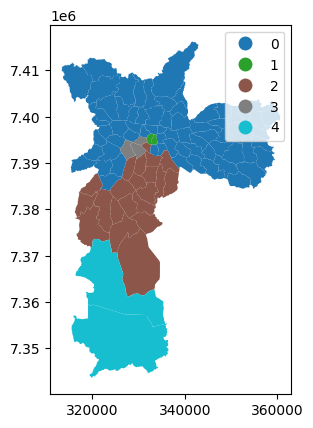

In [126]:
from libpysal.weights import Rook
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

def cluster_rook_contiguity(data, n_clusters):
    w = Rook.from_dataframe(data, use_index=False)
    adjacency_matrix = w.full()[0]

    scaler = StandardScaler()
    X = scaler.fit_transform(districts[["CRIMES"]])
    
    # ‘ward’ minimizes the variance of the clusters being merged.
    clustering = AgglomerativeClustering(n_clusters=n_clusters, connectivity=adjacency_matrix, linkage='ward').fit(X)
    
    districts["cluster"] = clustering.labels_
    
    return districts

# Example usage
districts_ = cluster_rook_contiguity(districts, n_clusters=5)

# Plot the districts by cluster, categorical colormap
districts_.plot(column="cluster", categorical=True, legend=True);


In [127]:
districts_.groupby("cluster").agg({"CRIMES": "sum"}).sort_values("CRIMES", ascending=False)

,CRIMES
cluster,
0,260931
2,131983
1,38510
3,37142
4,1838


In [130]:
districts_.cluster.value_counts()

cluster
0    68
2    21
3     3
4     2
1     2
Name: count, dtype: int64

In [133]:
tracts_validation_split = districts_[["NM_DISTRIT", "cluster"]].reset_index(drop=True)
tracts_validation_split

,NM_DISTRIT,cluster
0,ALTO DE PINHEIROS,0
1,ANHANGUERA,0
2,ARICANDUVA,0
3,ARTUR ALVIM,0
4,BARRA FUNDA,0
...,...,...
91,VILA MATILDE,0
92,VILA MEDEIROS,0
93,VILA PRUDENTE,0
94,VILA SÔNIA,0


In [135]:
tracts_validation_split.to_csv("../GENERATED-DATA/tracts_validation_split.csv", index=False)